In [1]:
%%capture

!pip install -U xarray[complete] # reinstala todo o xarray (útil nessa versão do colab por conta do cftime)

!pip install salem  #Instala o salem e o rasterio
!pip install rasterio

!pip install cartopy # Instala o cartopy

!pip install erddapy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importa as bibliotecas
import xarray as xr #Biblioteca para netcdf
import numpy as np
import requests #Biblioteca para fazer download direto do link htlm
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import salem #Biblioteca de recorte geoespacial
import cartopy.crs as ccrs #Biblioteca de criação de mapas
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
from scipy import stats


## Faz download dos shapefiles direto do link do github.

In [4]:
# URL do arquivo ZIP
url = "https://github.com/andrebelem/pythonverse/raw/main/datasets/SNIRH_UGRHs_2020.zip"

# Nome do arquivo local para salvar
nome_arquivo = "SNIRH_UGRHs_2020.zip"

# Faz o download do arquivo
response = requests.get(url)

# Verifica se a requisição foi bem-sucedida (código 200)
if response.status_code == 200:
    # Abre o arquivo local em modo de escrita em bytes
    with open(nome_arquivo, "wb") as f:
        # Escreve os dados no arquivo
        f.write(response.content)
    print("Download concluído com sucesso!")

Download concluído com sucesso!


## Plotagem da bacia do Paraguai!

In [6]:
#Abre o arquivo que contém as UGRHs
gdf = gpd.read_file("SNIRH_UGRHs_2020.zip")

# Filtrar a bacia desejada (exemplo usando o Paraná)
parana = gdf[gdf.NOME == "Paraná"]

##Download e organização
Dados: NCEP-NCAR Reanalysis 1- Dados Mensais

GPCC Global Precipitation Climatology Centre- Dados Mensais

In [6]:
# Importa o erddapy para fazer download dos dados de precipitação
from erddapy import ERDDAP

#Download dados NCEP
e = ERDDAP(
  server="https://upwell.pfeg.noaa.gov/erddap",
  protocol="griddap",
  response="opendap"
)
e.dataset_id = "noaa_psl_ec26_ccf5_e4d2"
ds_NCEP = e.to_xarray()

#Download dados GPCC  1°x1° 194?-2013
e = ERDDAP(
  server="https://upwell.pfeg.noaa.gov/erddap",
  protocol="griddap",
  response="opendap"
)
e.dataset_id = "noaa_psl_0af1_6bbc_d03b"
ds_GPCC1 = e.to_xarray()

#Download dados GPCC 1°x1° 2013-2024
e = ERDDAP(
  server="https://upwell.pfeg.noaa.gov/erddap",
  protocol="griddap",
  response="opendap"
)
e.dataset_id = "noaa_psl_51dc_c741_7c57"
ds_GPCC2 = e.to_xarray()

In [ ]:
#Concatena os dados do GPCC
ds_GPCC1 = ds_GPCC1.sel(time=slice("1901", "2011"))
ds_GPCC2 = ds_GPCC2.sel(time=slice("2012", "2024"))
ds_GPCC = xr.concat([ds_GPCC1, ds_GPCC2], dim='time')

#Transforma a unidade do NCEP de kg/m²/s para mm/mês
ds_NCEP['prate'] = ds_NCEP['prate'] * 86400 * 30 #Kg/m²/s --> mm/mes

In [ ]:
#Converte o grid de 0x360 lon para -180x180
ds_GPCC.coords['longitude'] = (ds_GPCC.coords['longitude'] + 180) % 360 - 180
ds_GPCC = ds_GPCC.sortby(ds_GPCC.longitude)

#Converte o grid de 0x360 lon para -180x180
ds_NCEP.coords['longitude'] = (ds_NCEP.coords['longitude'] + 180) % 360 - 180
ds_NCEP = ds_NCEP.sortby(ds_NCEP.longitude)

In [ ]:
# Faz um buffer para o shape pegar mais dados da grade
parana_exp = parana.buffer(0.5)

#Transforma para geodataframe para usar no salem
parana_exp = gpd.GeoDataFrame(geometry=parana_exp)
parana_exp.crs = parana.crs  # Atribua o mesmo CRS do GeoDataFrame original 'parana'

#Visualiza os shapes
parana.plot()
parana_exp.plot()

In [ ]:
#Código para fazer recorte dos dados para a região próxima
# Obter os limites do polígono (vértices extremos)
bounds = parana.geometry.bounds

# Extrair coordenadas dos limites
min_x, min_y, max_x, max_y = bounds.minx.min(), bounds.miny.min(), bounds.maxx.max(), bounds.maxy.max()

# Criar um quadrado com base nos limites
quadrado = Polygon([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])

# Criar um GeoDataFrame para o quadrado
quadrado_gdf = gpd.GeoDataFrame(geometry=[quadrado], crs=parana.crs)

In [ ]:
# Selecionar os dados usando a área de corte expandida
GPCC_sel = ds_GPCC['precip'].salem.subset(shape=quadrado_gdf)

# Selecionar os dados usando a área de corte expandida
NCEP_sel = ds_NCEP['prate'].salem.subset(shape=quadrado_gdf)

In [ ]:
#Recorta os dados para o shape
precip_GPCC = GPCC_sel.salem.roi(shape=parana_exp)
precip_NCEP = NCEP_sel.salem.roi(shape=parana_exp, all_touched=True)

In [ ]:
#Grava os arquivos no drive por segurança
precip_GPCC.to_netcdf("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/precip_GPCC.nc")
precip_NCEP.to_netcdf("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/precip_NCEP.nc")

## Rodar a partir daqui apenas

In [3]:
#Abre os arquivos no drive
precip_GPCC = xr.open_dataset("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/precip_GPCC.nc").precip
precip_NCEP = xr.open_dataset("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/precip_NCEP.nc").prate

NameError: name 'parana' is not defined

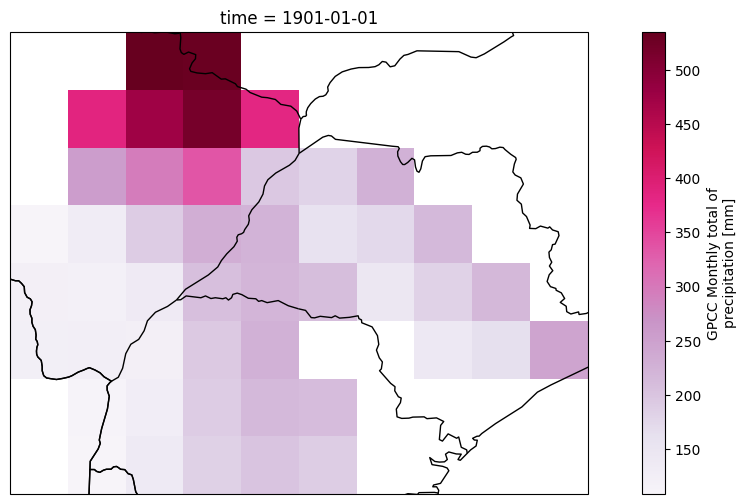

In [5]:
#Plota os dados na região para o GPCC
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
precip_GPCC.isel(time=0).plot(ax=ax,
            transform=ccrs.PlateCarree(), x='longitude', y='latitude',
            cmap='PuRd',
            add_colorbar=True)

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_lines')
contries = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_0_countries')

ax.add_feature(states, facecolor='none', edgecolor='black')
ax.add_feature(contries, facecolor='none', edgecolor='black')

parana.geometry.plot(ax=ax,facecolor='none',edgecolor='blue',linewidth=2)

ax.coastlines()

In [ ]:
#Plota os dados na região para o NCEP
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
precip_NCEP.isel(time=0).plot(ax=ax,
            transform=ccrs.PlateCarree(), x='longitude', y='latitude',
            cmap='PuRd',
            add_colorbar=True)

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_lines')
contries = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_0_countries')

ax.add_feature(states, facecolor='none', edgecolor='black')
ax.add_feature(contries, facecolor='none', edgecolor='black')

parana.geometry.plot(ax=ax,facecolor='none',edgecolor='blue',linewidth=2)

ax.coastlines()

##Plotagem e anomalias

In [7]:
#Cria a série temporal com os dados de grade para a área do shape
mean_GPCC = precip_GPCC.mean(dim=['latitude', 'longitude'])
mean_NCEP = precip_NCEP.mean(dim=['latitude', 'longitude'])

#Abre os dados do CESM-LENS
mean_CESM = xr.open_dataset("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/Media_precip_CESMLENS.nc")
mean_CESM["time"] = mean_CESM["time"].astype("datetime64[ns]") #Transforma o time do CESM para datetime

In [8]:
mean_CESM["PRECT"] = mean_CESM["PRECT"]

In [9]:
#Código para plotar anomalia anual no mesma figura das series temporais

#Agrupa por ano e soma
mean_NCEP_anual = mean_NCEP.groupby('time.year').sum()
mean_GPCC_anual = mean_GPCC.groupby('time.year').sum()
mean_CESM_anual = mean_CESM.groupby('time.year').sum()

#Renomeia por simplicidade
mean_NCEP_anual = mean_NCEP_anual.rename({"year" : "time"})
mean_GPCC_anual = mean_GPCC_anual.rename({"year" : "time"})
mean_CESM_anual = mean_CESM_anual.rename({"year" : "time"})

#Transforma os formatos para datetime, pois apos groupby eles ficam em int
mean_NCEP_anual['time'] = pd.to_datetime(mean_NCEP_anual['time'], format='%Y')
mean_GPCC_anual['time'] = pd.to_datetime(mean_GPCC_anual['time'], format='%Y')
mean_CESM_anual['time'] = pd.to_datetime(mean_CESM_anual['time'], format='%Y')


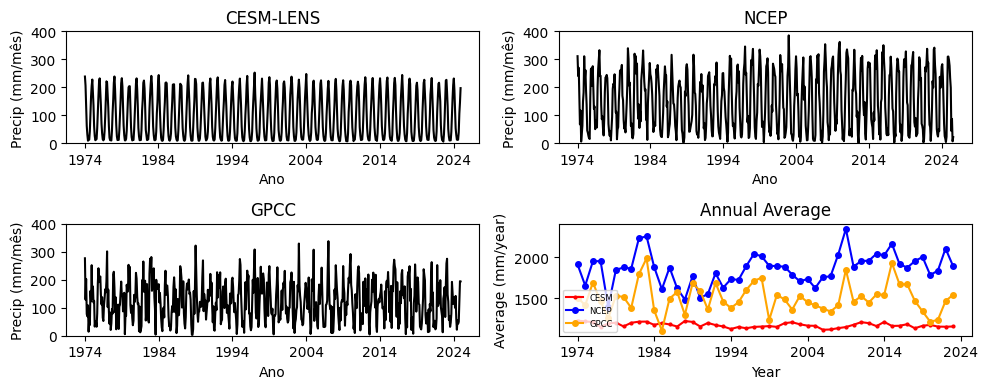

In [10]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

# Criar a figura e os eixos
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))

# Plotar os dados das séries temporais
(mean_CESM.PRECT).sel(time=slice("1974", "2025")).plot(ax=ax[0, 0], c='black')
(mean_NCEP).sel(time=slice("1974", "2025")).plot(ax=ax[0, 1], c='black')
(mean_GPCC).sel(time=slice("1974", "2025")).plot(ax=ax[1, 0], c='black')

#Plota as anomalais no último axes
(mean_CESM_anual.PRECT).sel(time=slice("1974", "2023")).plot(ax=ax[1, 1], label='CESM', marker='o', markersize=2, c='red')
(mean_NCEP_anual).sel(time=slice("1974", "2023")).plot(ax=ax[1, 1], label='NCEP', marker='o', markersize=4, c='blue')
(mean_GPCC_anual).sel(time=slice("1974", "2023")).plot(ax=ax[1, 1], label = 'GPCC', marker='o', markersize=4, c='orange')

# Configurar os rótulos do eixo x para exibir apenas os anos desejados
for ax_row in ax:
    for ax_col in ax_row:
        years = np.arange(1974, 2025, 10)  # Anos desejados
        years_num = date2num([np.datetime64(str(year), 'Y') for year in years])  # Converter as datas para números
        ax_col.set_xticks(years_num)  # Definir os ticks do eixo x nos anos desejados
        ax_col.set_xticklabels(years)


# Adicionar títulos nos eixos
ax[0, 0].set_xlabel('Ano')
ax[0, 0].set_ylabel('Precip (mm/mês)')
ax[0, 0].set_title('CESM-LENS')
ax[0,0].set_ylim(0, 400) # Define o limite do eixo y

ax[0, 1].set_xlabel('Ano')
ax[0, 1].set_ylabel('Precip (mm/mês)')
ax[0, 1].set_title('NCEP')
ax[0,1].set_ylim(0, 400) # Define o limite do eixo y

ax[1, 0].set_xlabel('Ano')
ax[1, 0].set_ylabel('Precip (mm/mês)')
ax[1, 0].set_title('GPCC')
ax[1,0].set_ylim(0, 400) # Define o limite do eixo y

ax[1, 1].set_xlabel('Year')
ax[1, 1].set_ylabel('Average (mm/year)')
ax[1, 1].set_title('Annual Average')
# Defie os yticks do ultimo plot
# ax[1, 1].set_yticks([-500, 0, 500])
# Se você quiser definir limites específicos para o último gráfico, pode fazer aqui:
# ax[1,1].set_ylim(limite_inferior, limite_superior)

# Ajustar o layout
plt.tight_layout()

#Exibir e posicionar a legenda
plt.legend(loc='lower left', fontsize='6')

# Exibir o plot
plt.savefig("Precipitação_Reanalies.png")
plt.show()


In [11]:
#Calcula as anomalias mensais
anom_NCEP = mean_NCEP - mean_NCEP.sel(time=slice('1980', '2010')).mean(dim='time')
anom_GPCC = mean_GPCC - mean_GPCC.sel(time=slice('1980', '2010')).mean(dim='time')
anom_CESM = mean_CESM - mean_CESM.sel(time=slice('1980', '2010')).mean(dim='time')

In [12]:
#Calcula as anomalias mensais
anom_NCEP_filt = anom_NCEP.sel(time=slice("1974", "2025"))
anom_GPCC_filt = anom_GPCC.sel(time=slice("1974", "2025"))
anom_CESM_filt = anom_CESM.PRECT.sel(time=slice("1974", "2025"))

In [13]:
import pandas as pd

# Adicionando uma linha de tendência linear até 2025
anom_year_NCEP= anom_NCEP_filt['time'].dt.year
anom_year_GPCC = anom_GPCC_filt['time'].dt.year
anom_year_CESM = anom_CESM_filt['time'].dt.year

NCEP_coef = np.polyfit(anom_year_NCEP, anom_NCEP_filt, 1)
GPCC_coef = np.polyfit(anom_year_GPCC, anom_GPCC_filt, 1)
CESM_coef = np.polyfit(anom_year_CESM, anom_CESM_filt, 1)

NCEP_trend = np.poly1d(NCEP_coef)
GPCC_trend = np.poly1d(GPCC_coef)
CESM_trend = np.poly1d(CESM_coef)

# Calculando a tendência linear para o período de 1975 a 2025
years_to_plot = pd.date_range(start='1970-01-01', end='2020-01-01', freq='Y')
NCEP_trend_values = NCEP_trend(years_to_plot.year)
GPCC_trend_values = GPCC_trend(years_to_plot.year)
CESM_trend_values = CESM_trend(years_to_plot.year)


/tmp/ipython-input-2391596362.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  years_to_plot = pd.date_range(start='1970-01-01', end='2020-01-01', freq='Y')


/tmp/ipython-input-3331786712.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(years_to_plot, NCEP_trend_values, 'b--', label='mm/mês', c='red')
/tmp/ipython-input-3331786712.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[1].plot(years_to_plot, GPCC_trend_values, 'b--', label='mm/mês', c='red')
/tmp/ipython-input-3331786712.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[2].plot(years_to_plot, CESM_trend_values, 'b--', label='mm/mês', c='red')


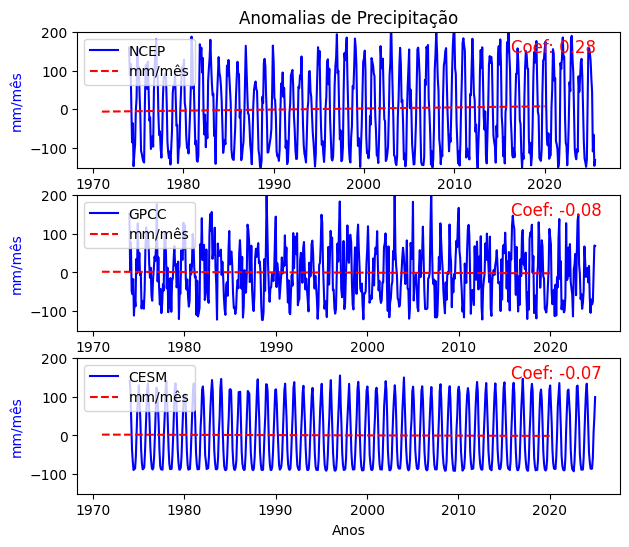

In [14]:
#Plotando as anomalias da série temporal completa
fig, ax = plt.subplots(figsize=(7,6), nrows=3)

ax[0].plot(anom_NCEP_filt.time, anom_NCEP_filt, 'b-', label='NCEP')

# Plotando as linhas de tendência
ax[0].plot(years_to_plot, NCEP_trend_values, 'b--', label='mm/mês', c='red')

ax[0].set_xlabel('Anos')
ax[0].set_ylabel('mm/mês', color='b')

# Adicionando as legendas fora do gráfico
ax[0].legend(loc='upper left')

# Adicionando texto com o coeficiente
ax[0].text(0.8, 0.85, f'Coef: {round(NCEP_coef[0], 2)}', transform=ax[0].transAxes, fontsize=12, color='red')

#Dando Título ao gráfico
ax[0].set_title("Anomalias de Precipitação")
ax[0].set_yticks([-200, 0, 200])
ax[0].set_ylim([-150, 200])
ax[0].set_yticks([-100, 0, 100, 200])

ax[1].plot(anom_GPCC_filt.time, anom_GPCC_filt, 'b-', label='GPCC')

# Plotando as linhas de tendência
ax[1].plot(years_to_plot, GPCC_trend_values, 'b--', label='mm/mês', c='red')

ax[1].set_xlabel('Anos')
ax[1].set_ylabel('mm/mês', color='b')
ax[1].text(0.8, 0.85, f'Coef: {round(GPCC_coef[0], 2)}', transform=ax[1].transAxes, fontsize=12, color='red')
ax[1].legend(loc='upper left')
ax[1].set_ylim([-150, 200])

ax[2].plot(anom_CESM_filt.time, anom_CESM_filt, 'b-', label='CESM')

# Plotando as linhas de tendência
ax[2].plot(years_to_plot, CESM_trend_values, 'b--', label='mm/mês', c='red')

ax[2].set_xlabel('Anos')
ax[2].set_ylabel('mm/mês', color='b')
ax[2].text(0.8, 0.85, f'Coef: {round(CESM_coef[0], 2)}', transform=ax[2].transAxes, fontsize=12, color='red')
ax[2].legend(loc='upper left')
ax[2].set_ylim([-150, 200])

plt.savefig('Anomalias de Precipitação Tendências')
plt.show()

## Plotagem boxplot para ver sazonalidade

In [15]:
#Transforma os dados em dataframe
df_GPCC = mean_GPCC.to_dataframe()
df_NCEP = mean_NCEP.to_dataframe()
df_CESM = mean_CESM.PRECT.to_dataframe()

In [16]:
#Agrupa por mês
df_GPCC_new = df_GPCC['precip'].reset_index()
df_GPCC_new['month'] = df_GPCC_new['time'].dt.month
df_NCEP_new = df_NCEP['prate'].reset_index()
df_NCEP_new['month'] = df_NCEP_new['time'].dt.month
df_CESM_new = df_CESM['PRECT'].reset_index()
df_CESM_new['month'] = df_CESM_new['time'].dt.month

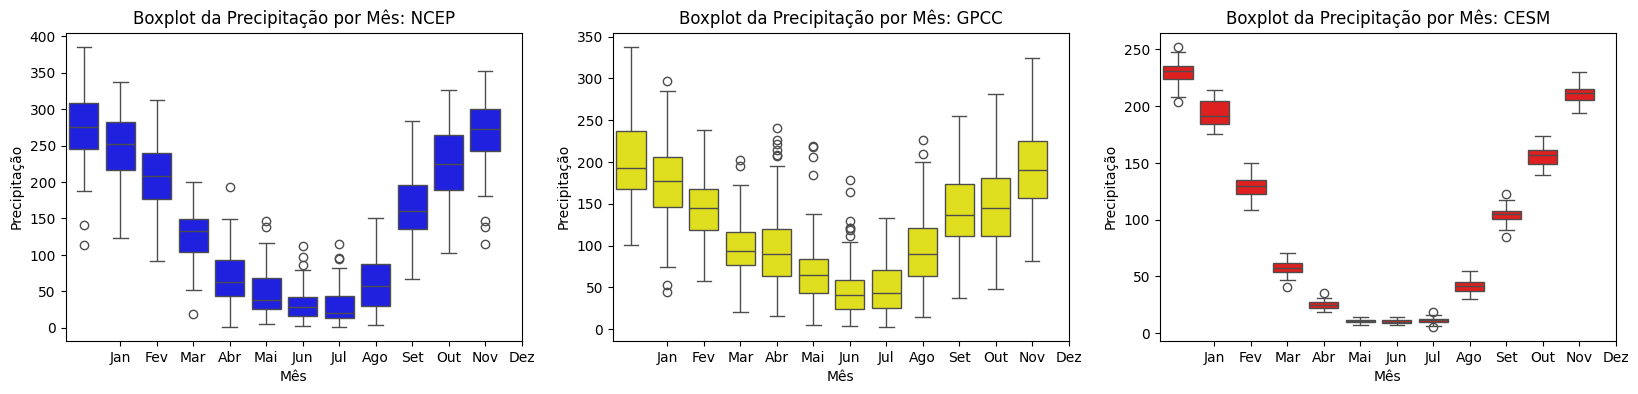

In [17]:
import seaborn as sns

#Realiza o plot
fig, ax = plt.subplots(ncols=3, figsize= (20, 4))

# Plotando o boxplot
sns.boxplot(ax=ax[0], x=df_NCEP_new.month, y=df_NCEP_new['prate'], color='blue')
ax[0].set_title('Boxplot da Precipitação por Mês: NCEP')
ax[0].set_xlabel('Mês')
ax[0].set_ylabel('Precipitação')
ax[0].set_xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
sns.boxplot(ax=ax[1], x=df_GPCC_new.month, y=df_GPCC_new['precip'], color='yellow')
ax[1].set_title('Boxplot da Precipitação por Mês: GPCC')
ax[1].set_xlabel('Mês')
ax[1].set_ylabel('Precipitação')
ax[1].set_xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
sns.boxplot(ax=ax[2], x=df_CESM_new.month, y=df_CESM_new['PRECT'], color='red')
ax[2].set_title('Boxplot da Precipitação por Mês: CESM')
ax[2].set_xlabel('Mês')
ax[2].set_ylabel('Precipitação')
ax[2].set_xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.savefig("Boxplot_precip.png")
plt.show()

##Tendencia Anual

In [18]:
#Agrupa os dados por ano e soma
mean_NCEP_anual = mean_NCEP.groupby('time.year').sum()
mean_GPCC_anual = mean_GPCC.groupby('time.year').sum()
mean_CESM_anual = mean_CESM.groupby('time.year').sum()

#Renomeia a variavel year parar time
mean_NCEP_anual= mean_NCEP_anual.rename({"year" : "time"})
mean_GPCC_anual = mean_GPCC_anual.rename({"year" : "time"})
mean_CESM_anual = mean_CESM_anual.rename({"year" : "time"})

In [19]:
#Calcula as anomalias com base no periodo de referência
anom_NCEP_anual = mean_NCEP_anual - mean_NCEP_anual.sel(time=slice('1980', '2010')).mean(dim='time')
anom_GPCC_anual = mean_GPCC_anual - mean_GPCC_anual.sel(time=slice('1980', '2010')).mean(dim='time')
anom_CESM_anual = mean_CESM_anual - mean_CESM_anual.sel(time=slice('1980', '2010')).mean(dim='time')

In [20]:
#Seleciona o tempo de análise, retira 2024, devido a soma da precip. (2024 não tem todos os meses)
anom_NCEP_filt = anom_NCEP_anual.sel(time=slice("1974", "2023"))
anom_GPCC_filt = anom_GPCC_anual.sel(time=slice("1974", "2023"))
anom_CESM_filt = anom_CESM_anual.PRECT.sel(time=slice("1974", "2023"))

In [21]:
# Adicionando uma linha de tendência linear até 2023
import numpy as np

anom_year_NCEP = anom_NCEP_filt['time'].values
anom_year_GPCC = anom_GPCC_filt['time'].values
anom_year_CESM = anom_CESM_filt['time'].values

NCEP_coef = np.polyfit(anom_year_NCEP, anom_NCEP_filt, 1)
GPCC_coef = np.polyfit(anom_year_GPCC, anom_GPCC_filt, 1)
CESM_coef = np.polyfit(anom_year_CESM, anom_CESM_filt, 1)

NCEP_trend = np.poly1d(NCEP_coef)
GPCC_trend = np.poly1d(GPCC_coef)
CESM_trend = np.poly1d(CESM_coef)

# Calculando a tendência linear para o período de 1974 a 2023
years_to_plot = np.arange(1974, 2023, 1)
NCEP_trend_values = NCEP_trend(years_to_plot)
GPCC_trend_values = GPCC_trend(years_to_plot)
CESM_trend_values = CESM_trend(years_to_plot)


/tmp/ipython-input-4236298770.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(years_to_plot, NCEP_trend_values, 'b--', label='mm/ano', c='red')
/tmp/ipython-input-4236298770.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[1].plot(years_to_plot, GPCC_trend_values, 'b--', label='mm/ano', c='red',)
/tmp/ipython-input-4236298770.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[2].plot(years_to_plot, CESM_trend_values, 'b--', label='mm/ano', c='red')


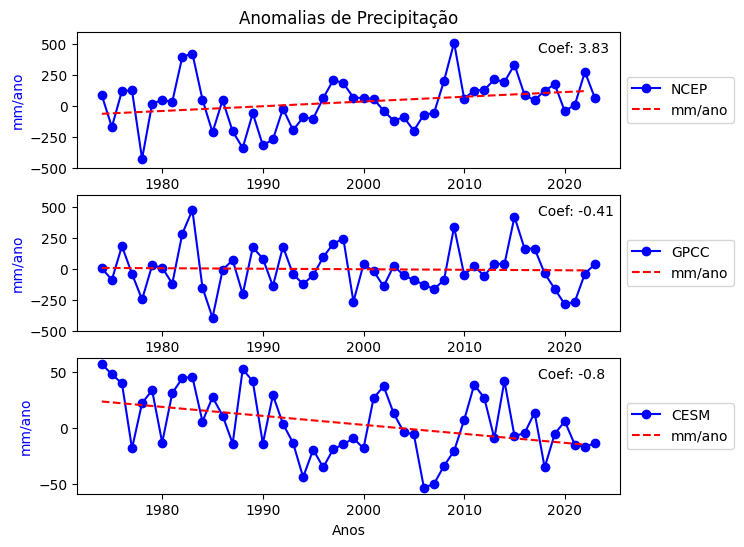

In [22]:
#Plotagem das anomalias acumuladas anuais
fig, ax = plt.subplots(figsize=(7,6), nrows=3)

ax[0].plot(anom_NCEP_filt.time, anom_NCEP_filt, 'b-', label='NCEP',  marker='o')

# Plotando as linhas de tendência
ax[0].plot(years_to_plot, NCEP_trend_values, 'b--', label='mm/ano', c='red')

ax[0].set_xlabel('Anos')
ax[0].set_ylabel('mm/ano', color='b')

# Adicionando as legendas fora do gráfico
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adicionando texto com o coeficiente
ax[0].text(0.85, 0.85, f'Coef: {round(NCEP_coef[0], 2)}', transform=ax[0].transAxes, fontsize=10, color='black')

#Dando Título ao gráfico
ax[0].set_title("Anomalias de Precipitação")
ax[0].set_ylim([-500, 600])
ax[0].set_yticks([-500, -250, 0, 250, 500])

ax[1].plot(anom_GPCC_filt.time, anom_GPCC_filt, 'b-', label='GPCC', marker='o')

# Plotando as linhas de tendência
ax[1].plot(years_to_plot, GPCC_trend_values, 'b--', label='mm/ano', c='red',)

ax[1].set_xlabel('Anos')
ax[1].set_ylabel('mm/ano', color='b')
ax[1].set_ylim([-500, 600])
ax[1].set_yticks([-500, -250, 0, 250, 500])
ax[1].text(0.85, 0.85, f'Coef: {round(GPCC_coef[0], 2)}', transform=ax[1].transAxes, fontsize=10, color='black')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[2].plot(anom_CESM_filt.time, anom_CESM_filt, 'b-', label='CESM', marker='o')

# Plotando as linhas de tendência
ax[2].plot(years_to_plot, CESM_trend_values, 'b--', label='mm/ano', c='red')

ax[2].set_xlabel('Anos')
ax[2].set_ylabel('mm/ano', color='b')
ax[2].text(0.85, 0.85, f'Coef: {round(CESM_coef[0], 2)}', transform=ax[2].transAxes, fontsize=10, color='black')
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('Anomalias_prec_anuais.png')
plt.show()

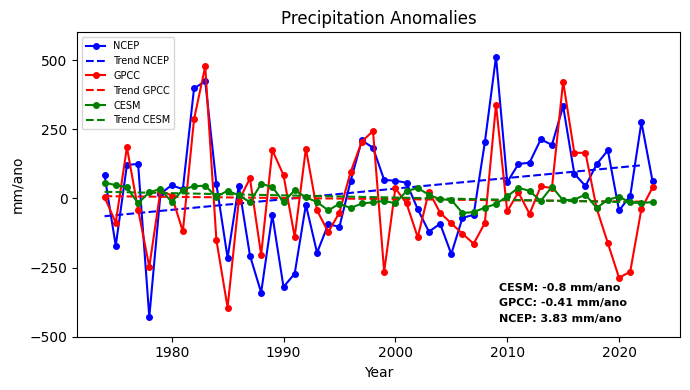

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

# -------------------
# NCEP
# -------------------
ax.plot(anom_NCEP_filt.time, anom_NCEP_filt, 'b-', label='NCEP', marker='o', markersize=4)
ax.plot(years_to_plot, NCEP_trend_values, 'b--', label='Trend NCEP')
ax.text(0.7, 0.05, f'NCEP: {round(NCEP_coef[0],2)} mm/ano',
        transform=ax.transAxes, fontsize=8, color='black', fontweight='bold')

# -------------------
# GPCC
# -------------------
ax.plot(anom_GPCC_filt.time, anom_GPCC_filt, 'r-', label='GPCC', marker='o', markersize=4)
ax.plot(years_to_plot, GPCC_trend_values, 'r--', label='Trend GPCC')
ax.text(0.7, 0.10, f'GPCC: {round(GPCC_coef[0],2)} mm/ano',
        transform=ax.transAxes, fontsize=8, color='black', fontweight='bold')

# -------------------
# CESM
# -------------------
ax.plot(anom_CESM_filt.time, anom_CESM_filt, 'g-', label='CESM', marker='o', markersize=4)
ax.plot(years_to_plot, CESM_trend_values, 'g--', label='Trend CESM')
ax.text(0.7, 0.15, f'CESM: {round(CESM_coef[0],2)} mm/ano',
        transform=ax.transAxes, fontsize=8, color='black', fontweight='bold')

# -------------------
# Configurações gerais
# -------------------
ax.set_xlabel('Year')
ax.set_ylabel('mm/ano')
ax.set_title("Precipitation Anomalies")
ax.set_ylim([-500, 600])
ax.set_yticks([-500, -250, 0, 250, 500])

# Legenda fora do gráfico
ax.legend(loc='upper left', fontsize=7)

plt.tight_layout()
plt.savefig('Anomalias_prec_anuais.png')
plt.show()